<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/2019_tf/airline2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline Embeddings

_Basic assumption: airlines fliying similar routes are similar_

## Data Sets
* Single Flights: http://stat-computing.org/dataexpo/2009/the-data.html
* Routes between airports: https://openflights.org/data.html#route


In [104]:
!curl -O https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  4130k      0 --:--:-- --:--:-- --:--:-- 4123k


In [0]:
# pd.read_csv?

In [106]:
import pandas as pd

df = pd.read_csv('routes.dat', quotechar="'", sep=',', encoding='utf-8', header=None, na_values='\\N',
                names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

# https://openflights.org/data.html#route
  
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

# df[df['Stops'] == 1] gives only a dozen or so routes, so also drop it
df.drop(['Airline ID',	'Source airport ID', 'Destination airport ID', 'Codeshare', 'Equipment', 'Stops'], axis='columns', inplace=True)
len(df)

67663

In [107]:
df.head()

,Airline,Source airport,Destination airport
0,2B,AER,KZN
1,2B,ASF,KZN
2,2B,ASF,MRV
3,2B,CEK,KZN
4,2B,CEK,OVB


In [108]:
sources = df['Source airport'].unique()
len(sources)

3409

In [109]:
destinations = df['Destination airport'].unique()
len(destinations)

3418

In [110]:
airlines = df['Airline'].unique()
len(airlines)

568

In [111]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.0-rc1


In [112]:
from tensorflow.keras.preprocessing.text import Tokenizer

airline_tokenizer = Tokenizer()
airline_tokenizer.fit_on_texts(df['Airline'])

import numpy as np

encoded_airlines = np.array(airline_tokenizer.texts_to_sequences(df['Airline'])).reshape(-1)
encoded_airlines

array([241, 241, 241, ..., 543, 543, 543])

In [113]:
len(encoded_airlines) 

67663

In [114]:
routes = df[['Source airport', 'Destination airport']].apply(lambda x: ' '.join(x), axis=1)
routes.head()

0    AER KZN
1    ASF KZN
2    ASF MRV
3    CEK KZN
4    CEK OVB
dtype: object

In [0]:
routes_tokenizer = Tokenizer()
routes_tokenizer.fit_on_texts(routes)
encoded_routes = np.array(routes_tokenizer.texts_to_sequences(routes))

In [116]:
# should be a bit more 3400 as source and destination are from the same set
output_dim = len(routes_tokenizer.word_index) + 1
output_dim

3426

In [117]:
encoded_routes[0]

array([511, 491])

In [118]:
len(encoded_routes)

67663

In [0]:
from tensorflow.keras.utils import to_categorical

# sequence of airlines encoded as a unique number
x = encoded_airlines
# sequence of pair, src, dest encoded as a unique numbers
Y = to_categorical(encoded_routes)
# for now just the source
# Y = to_categorical(encoded_routes[:, 0])

In [120]:
Y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## 2d embeddings

In [121]:
%%time

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, GlobalAveragePooling1D, Dense, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, RepeatVector
from tensorflow.keras.models import Sequential, Model

input_dim = len(airlines) + 1
embedding_dim = 2

model = Sequential()

model.add(Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units=50, activation='relu'))

model.add(RepeatVector(2))

model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Dense(units=output_dim, name='output', activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 2)              1138      
_________________________________________________________________
flatten_6 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                150       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 181,064
Trainable params: 181,064
Non-trainable params: 0
_________________________________________________________________
CPU 

In [122]:
model.predict(np.array([x[0]]))

array([[[0.00029181, 0.00029179, 0.00029189, ..., 0.00029202,
         0.00029182, 0.00029161],
        [0.00029212, 0.00029209, 0.00029173, ..., 0.00029229,
         0.00029179, 0.00029207]]], dtype=float32)

In [123]:
Y[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Epoch 1/20
67663/67663 [==============================] - 10s 152us/sample - loss: 6.7569 - acc: 0.0143
Epoch 2/20
67663/67663 [==============================] - 10s 146us/sample - loss: 6.1587 - acc: 0.0258
Epoch 3/20
67663/67663 [==============================] - 10s 141us/sample - loss: 5.7062 - acc: 0.0485
Epoch 4/20
67663/67663 [==============================] - 10s 141us/sample - loss: 5.3678 - acc: 0.0728
Epoch 5/20
67663/67663 [==============================] - 10s 143us/sample - loss: 5.1540 - acc: 0.0891
Epoch 6/20
67663/67663 [==============================] - 10s 142us/sample - loss: 5.0079 - acc: 0.1020
Epoch 7/20
67663/67663 [==============================] - 10s 142us/sample - loss: 4.8974 - acc: 0.1140
Epoch 8/20
67663/67663 [==============================] - 10s 142us/sample - loss: 4.8108 - acc: 0.1217
Epoch 9/20
67663/67663 [==============================] - 10s 141us/sample - loss: 4.7422 - acc: 0.1272
Epoch 10/20
67663/67663 [==============================] - 10s 1

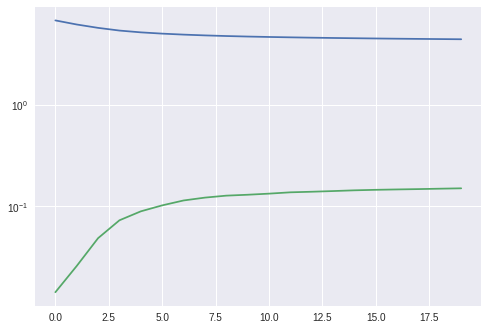

In [124]:
%%time

EPOCHS=20
BATCH_SIZE=100

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

In [125]:
loss, accuracy = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss, accuracy

67663/67663 [==============================] - 6s 81us/sample - loss: 4.3739 - acc: 0.1526


(4.373894038322366, 0.15256491)

In [0]:
samples = pd.DataFrame(encoded_airlines).sample(n=200).values.reshape(-1)

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(samples).reshape(-1, 2)

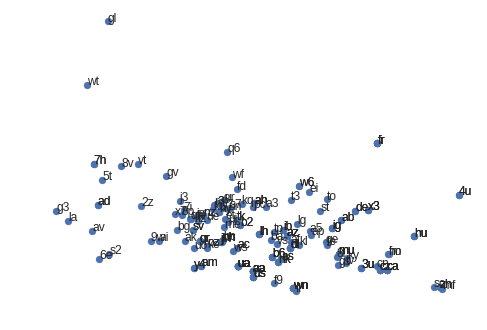

In [140]:
# for printing only
# plt.figure(dpi=600)
plt.axis('off')
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for index, x_pos, y_pos in zip(samples, embeddings_2d[:, 0], embeddings_2d[:, 1]):
  name = airline_tokenizer.index_word[index]
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos))